# Aprendizaje Automático II - Trabajo Práctico N°1

- Antuña, Franco (A-4637/1)
- Asad, Gonzalo (A-4595/1)
- Castells, Sergio (C-7334/2)

----------------

# Preparación del Entorno

In [1]:
!pip install gdown

In [2]:
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import statsmodels.api as sm

import joblib

import tensorflow as tf

# Problema 1

## Preparación del Dataset

In [3]:
# Definir el ID del archivo
file_id = '1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc'

# Crear la URL de descarga
download_url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo
output = 'TP1-1-student_performance.zip'
gdown.download(download_url, output, quiet=True)

# Descomprimir el .zip
!unzip TP1-1-student_performance.zip

# Cargar el dataset
df_p1 = pd.read_csv('Student_Performance.csv')

Archive:  TP1-1-student_performance.zip
  inflating: Student_Performance.csv  


Eliminamos todas las filas donde la variable 'Performance Index' tiene valor NaN, ya que pierde el sentido tenerlas si vamos a hacer un modelo que las prediga.

In [4]:
df_p1_filtrado = df_p1.copy()
index_NaN = df_p1[df_p1['Performance Index'].isna()].index
df_p1_filtrado.drop(index_NaN, inplace=True)
df_p1_filtrado.reset_index(drop=True, inplace=True)

Hacemos la separación del dataset entre la variable de salida 'Performance Index' y el resto de los datos. A estos últimos los separamos entre datasets de entrenamiento y de pruebas.

In [5]:
# Dividimos el dataset en datos de entrenamiento y de testeo
X = df_p1_filtrado.drop('Performance Index', axis=1)
y = df_p1_filtrado['Performance Index']

# Creamos datasets de entrenamiento y de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000, 1), (2000, 1))

## Análisis Descriptivo

Observamos rápidamente el contenido del dataset de entrenamiento.

In [6]:
train_data = X_train.reset_index(drop=True)
train_data = pd.concat([train_data, pd.DataFrame(y_train, columns=['Performance Index'])], axis=1)
train_data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,5,49,No,7,5,36.0
1,2,48,Yes,7,6,25.0
2,2,81,No,7,2,59.0
3,2,46,No,6,1,22.0
4,8,47,No,9,0,40.0


Estudiamos el tipo de los datos.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     8000 non-null   int64  
 1   Previous Scores                   8000 non-null   int64  
 2   Extracurricular Activities        8000 non-null   object 
 3   Sleep Hours                       8000 non-null   int64  
 4   Sample Question Papers Practiced  8000 non-null   int64  
 5   Performance Index                 8000 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 375.1+ KB


Vemos que la mayoría de las variables son del tipo 'int64' a excepción de 'Extracurricular Activities' y 'Performance Index ', que son del tipo 'object' y 'float64' respectivamente. Observamos las características descriptivas del dataset.

In [8]:
train_data.describe(include='all')

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,8000.000000,8000.000000,8000,8000.000000,8000.000000,8000.000000
unique,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,No,NaN,NaN,NaN
freq,NaN,NaN,4043,NaN,NaN,NaN
mean,4.983250,69.531000,NaN,6.541625,4.616500,55.311500
std,2.594862,17.343735,NaN,1.698493,2.861241,19.202059
min,1.000000,40.000000,NaN,4.000000,0.000000,10.000000
25%,3.000000,54.750000,NaN,5.000000,2.000000,40.000000
50%,5.000000,70.000000,NaN,7.000000,5.000000,55.000000
75%,7.000000,85.000000,NaN,8.000000,7.000000,71.000000


No se encuentran desvíos ni nada fuera de lo común.

## Análisis Exploratorio

Filtramos las variables del tipo Object.

In [9]:
non_categoric_cols = train_data.select_dtypes(exclude='object').columns

Para evitar mensajes asociados a cambios planeados en futuras versiones de las librerías en uso, hacemos uso de la función 'filterwarnings'.

In [10]:
warnings.filterwarnings('ignore', category=FutureWarning)

Graficamos los diagramas de caja y bigotes junto con los histogramas de cada variable numérica.

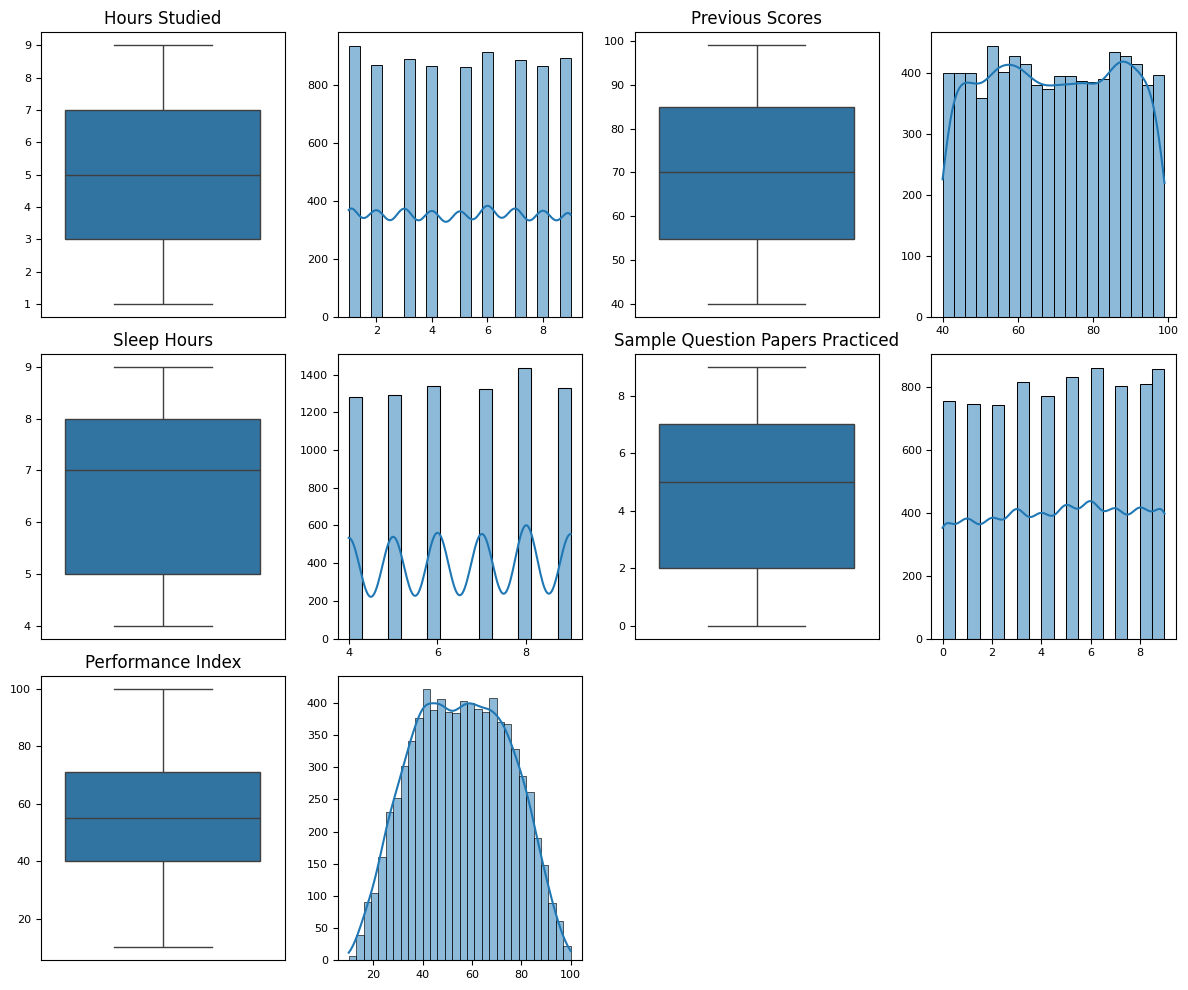

In [11]:
# Crear diagrama de caja individual para cada variable
plt.figure(figsize=(12, 10))
idx = 0
for column in non_categoric_cols:
    # Boxplot
    plt.subplot(3, 4, idx+1)
    sns.boxplot(data = train_data[column])
    plt.title(column)
    plt.ylabel('')
    plt.xticks([])
    plt.yticks(fontsize=8)

    # Distplot
    plt.subplot(3, 4, idx+2)
    sns.histplot(data=train_data, x=column, kde=True)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    idx += 2

plt.tight_layout()
plt.show()

Todas las variables mantienen distribuciones altamente uniformes, a excepción de "Performance Index", que tiene una forma más campanular (no necesariamente normal). A su vez, esta última variable posee dos modas, cerca de los 8 puntos y los 4 puntos, indicando una tendencia.

Graficamos las dispersiones entre todos los pares de variables numéricas.

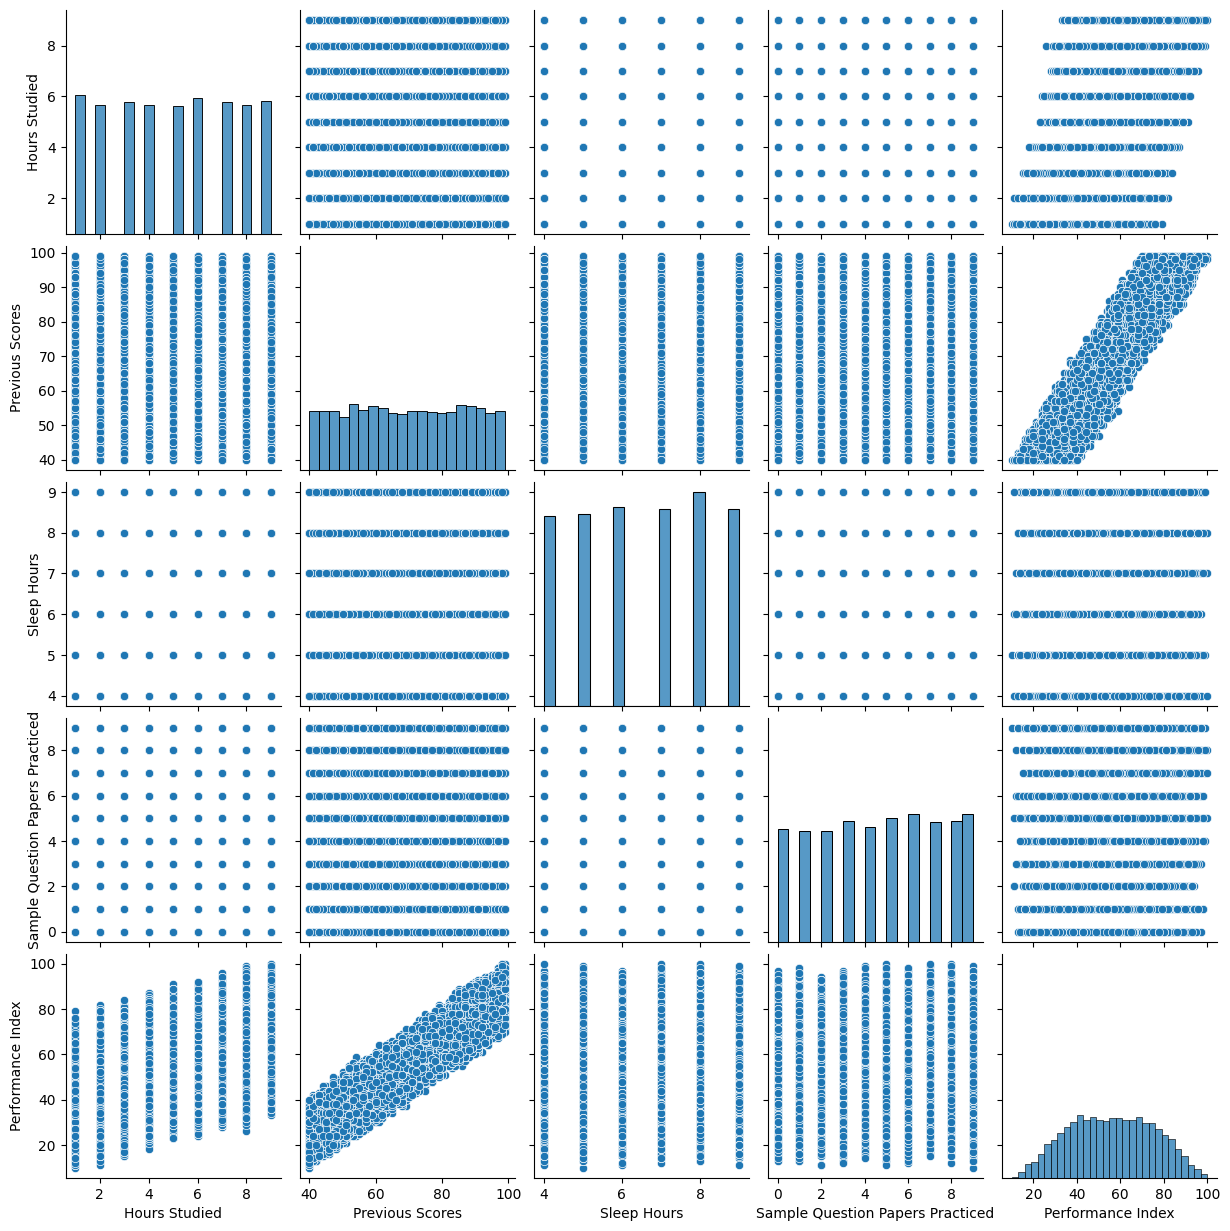

In [12]:
sns.pairplot(train_data[non_categoric_cols])
plt.show()

En una observación preliminar, parecería ser que el par de variables "Previous Scores" y "Performance Index" poseen una correlación lineal entre ellas. En menor medida, ocurre también con "Performance Index" y "Hours Studied", pero con una mayor dispersión de los datos. No se pueden detectar otros patrones interesantes entre el resto de pares de datos.

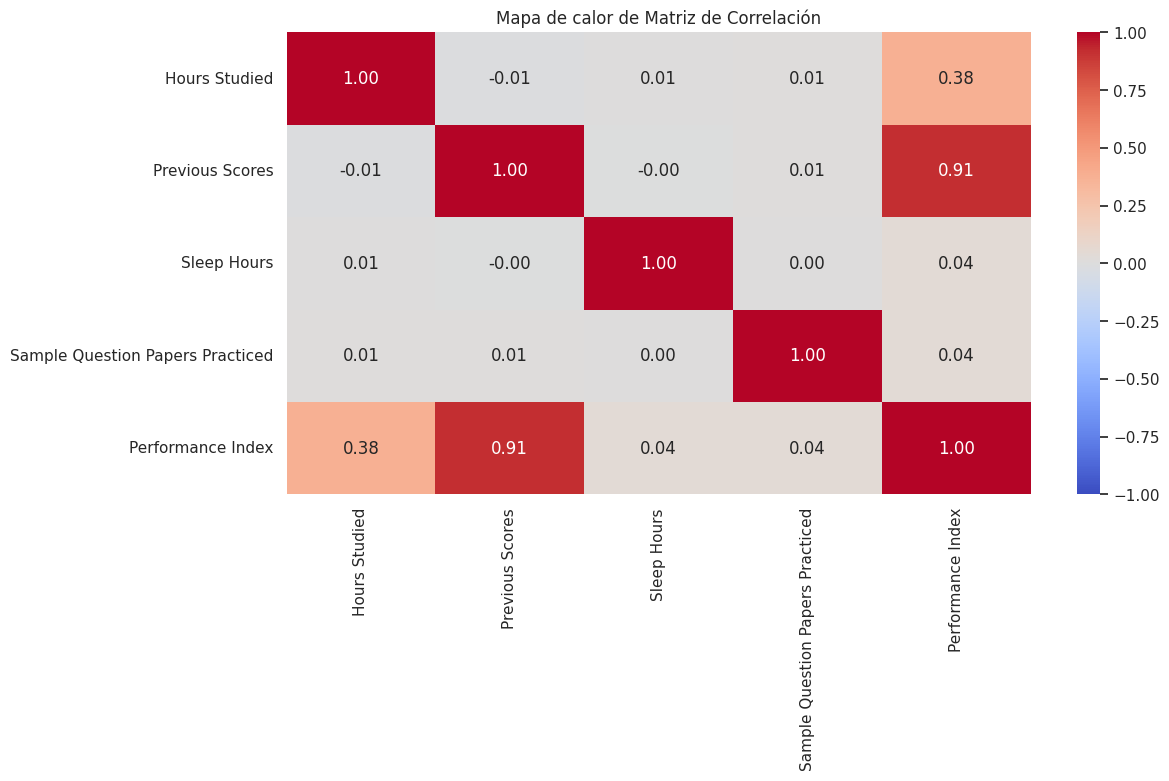

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.heatmap(train_data[non_categoric_cols].corr(method = 'pearson'), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa de calor de Matriz de Correlación')
plt.show()

El mapa de correlación confirma las hipótesis propuestas en el apartado anterior, donde se observan correlaciones lineales débiles y fuertes entre "Performance Index" / "Hours Studied" y "Performance Index" / "Previous Scores" respectivamente. En el caso de la correlación lineal fuerte, tiene todo el sentido, ya que son las notas previas las que definen el rendimiento final del estudiante.

No se observan otras correlaciones lineales entre variables, lo que no significa que no haya correlaciones de otro tipo.

## Limpieza, Imputación y Escalado

Analizamos la existencia de datos duplicados.

In [14]:
X_train.duplicated().sum()

np.int64(503)

Encontramos datos duplicados que representan cerca del 5% del total de los datos, por lo que las eliminamos???

In [15]:
# X_train.drop_duplicates(inplace=True)

Validamos que no haya datos nulos.

In [16]:
X_train.isna().sum()

,0
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0


No se han encontrado datos nulos, por lo que no será necesario aplicar una imputación. Codificamos entonces la columna 'Extracurriculr Activities'.

In [17]:
# CODIFICACIÓN DE LA VARIABLE "Extracurricular Activities"" --> Se implementa codificación binaria
X_train_modified = X_train.copy()
X_test_modified = X_test.copy()

X_train_modified['Extracurricular Activities'] = X_train_modified['Extracurricular Activities'].map({'Yes': 1, 'No': 0}, na_action='ignore')
X_test_modified['Extracurricular Activities'] = X_test_modified['Extracurricular Activities'].map({'Yes': 1, 'No': 0}, na_action='ignore')

Siendo que el dataset no tiene outliers, escalamos usando un escalador estándar, llevando los datos al rango (-1, 1).

In [18]:
# Definición de columnas a escalar
cols_to_scale = X_train_modified.columns.difference(['Extracurricular Activities'])

# Creación del escalador y datasets
scaler = StandardScaler()
X_train_scaled = X_train_modified.copy()
X_test_scaled = X_test_modified.copy()

# Escalado de datasets
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_modified[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_modified[cols_to_scale])

## Modelo de Regresión con Redes Neuronales

Creamos un modelo de regresión utilizando redes neuronales.

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(units=32, activation='sigmoid'),
    tf.keras.layers.Dense(units=16, activation='sigmoid'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'r2_score'])

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3142.6926 - mae: 52.6417 - mse: 3142.6926 - r2_score: -7.4656 - val_loss: 2781.1868 - val_mae: 49.1383 - val_mse: 2781.1868 - val_r2_score: -6.5250
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2753.6785 - mae: 48.8345 - mse: 2753.6785 - r2_score: -6.4298 - val_loss: 2534.1370 - val_mae: 46.5444 - val_mse: 2534.1370 - val_r2_score: -5.8565
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2480.6748 - mae: 45.9632 - mse: 2480.6748 - r2_score: -5.7137 - val_loss: 2329.0901 - val_mae: 44.2794 - val_mse: 2329.0901 - val_r2_score: -5.3017
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2277.4639 - mae: 43.7674 - mse: 2277.4639 - r2_score: -5.2851 - val_loss: 2144.0791 - val_mae: 42.1377 - val_mse: 2144.0791 - val_r2_score: -4.8012
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2094.3159 - mae: 41.5738 - mse: 2094.3159 - r2_score: -4.7123 - val_loss: 1974.3857 - val_mae: 40.0796 

Luego, ploteamos la historia del MSE y el MAE.

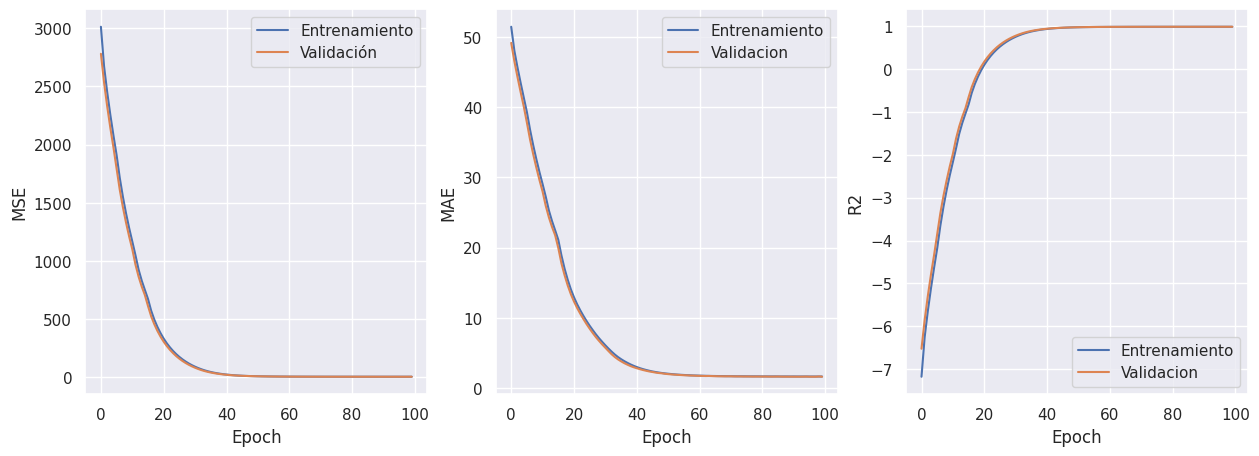

In [38]:
# Ploteamos la historia del MSE y el MAE
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['mse'], label = 'Entrenamiento')
plt.plot(history.history['val_mse'], label = 'Validación')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label = 'Validacion')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(history.history['r2_score'], label='Entrenamiento')
plt.plot(history.history['val_r2_score'], label = 'Validacion')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend(loc='lower right')

Se observa que a medida que las épocas avanzan, las métricas mejoran de forma casi exponencial, hasta un punto en donde se hace difícil discernir mejoras significativas.

Ensayamos luego un modelo más complejo.

In [53]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

model_2.summary()

model_2.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'r2_score'])

history_2 = model_2.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 512)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,057 (301.00 KB)

 Trainable params: 77,057 (301.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1313.3926 - mae: 26.9194 - mse: 1313.3926 - r2_score: -2.5968 - val_loss: 45.2975 - val_mae: 5.3108 - val_mse: 45.2975 - val_r2_score: 0.8774
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 36.4095 - mae: 4.6986 - mse: 36.4095 - r2_score: 0.9036 - val_loss: 13.4194 - val_mae: 2.9115 - val_mse: 13.4194 - val_r2_score: 0.9637
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.5952 - mae: 2.5432 - mse: 10.5952 - r2_score: 0.9716 - val_loss: 5.4593 - val_mae: 1.8655 - val_mse: 5.4593 - val_r2_score: 0.9852
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2637 - mae: 1.8028 - mse: 5.2637 - r2_score: 0.9857 - val_loss: 4.5612 - val_mae: 1.6996 - val_mse: 4.5612 - val_r2_score: 0.9877
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8728 - mae: 1.7550 - mse: 4.8728 - r2_score: 0.9868 - val_loss: 5.2449 - val_mae: 1.8137 - val_mse: 5.2449 - val_r2_score: 0.9858
Epoch 6/30
200/200 ━━━━━

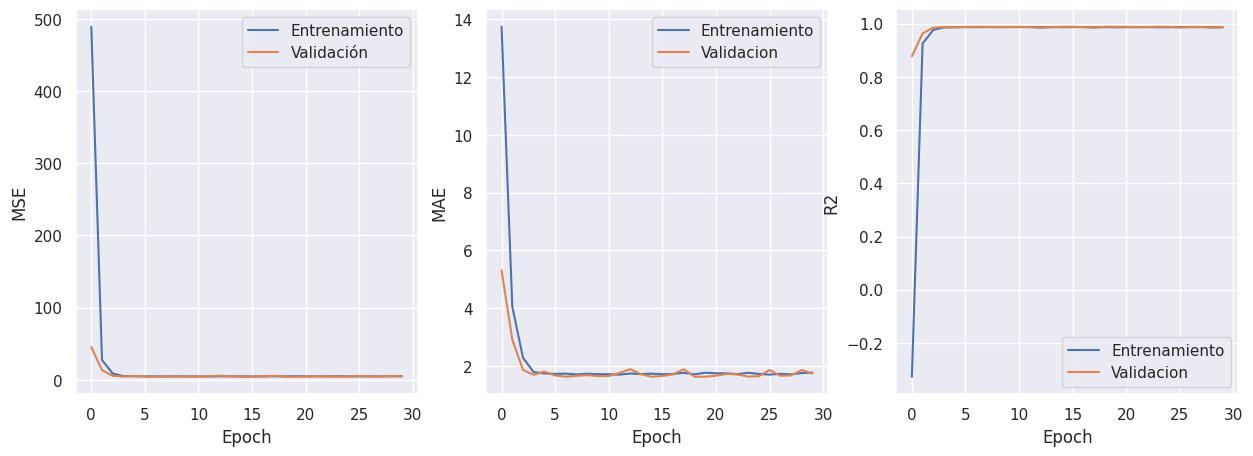

In [54]:
# Ploteamos la historia del MSE y el MAE
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history_2.history['mse'], label = 'Entrenamiento')
plt.plot(history_2.history['val_mse'], label = 'Validación')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(history_2.history['mae'], label='Entrenamiento')
plt.plot(history_2.history['val_mae'], label = 'Validacion')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(history_2.history['r2_score'], label='Entrenamiento')
plt.plot(history_2.history['val_r2_score'], label = 'Validacion')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend(loc='lower right')

Observamos que no hay una diferencia significativa en las métricas finales obtenidas, sin embargo, el modelo converge en menos épocas (su entrenamiento es más rápido).

Evaluamos el desempeño del modelo utilizando los datos de entrenamiento y prueba.

In [55]:
# Realizamos las predicciones
y_pred = model_2.predict(X_test_scaled)

# Evaluamos el modelo con los datos de entrenamiento
train_loss, train_mse, train_mae, train_r2 = model_2.evaluate(X_train_scaled, y_train)
print(f"Train MSE: {train_mse:.4f} - Train MAE: {train_mae:.4f} - Train R2: {train_r2:.4f}")

# Evaluamos el modelo con los datos de prueba
test_loss, test_mse, test_mae, test_r2 = model_2.evaluate(X_test_scaled, y_test)
print(f"Test MSE: {test_mse:.4f} - Test MAE: {test_mae:.4f} - Test R2: {test_r2:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6783 - mae: 1.7226 - mse: 4.6783 - r2_score: 0.9873
Train MSE: 4.6674 - Train MAE: 1.7244 - Train R2: 0.9873
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6480 - mae: 1.7213 - mse: 4.6480 - r2_score: 0.9879
Test MSE: 4.6574 - Test MAE: 1.7324 - Test R2: 0.9874


Las métricas de entrenamiento y de pruebas son similares, por lo que no se ven signos de sobreajuste o subajuste. El alto valor de R2 nos asegura que un gran porcentaje de la variabilidad de los datos es representado por el modelo.

Graficamos luego los residuos.

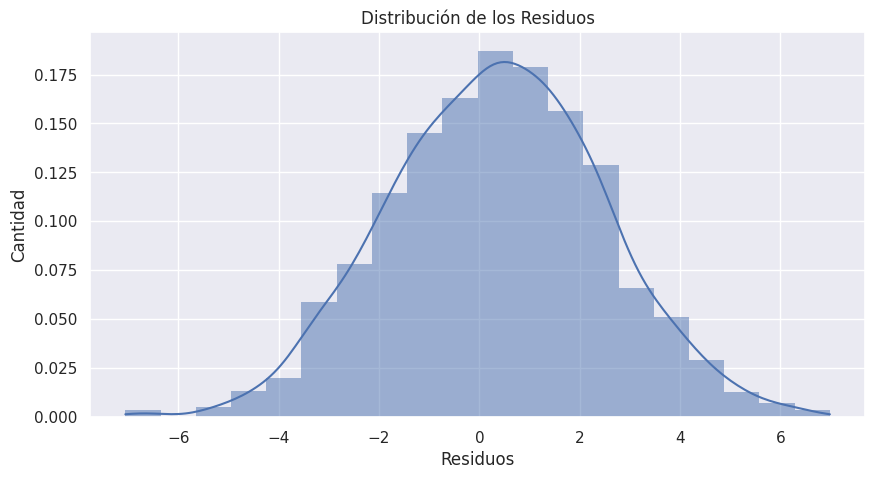

In [66]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")

# Gráfico de distribución de los residuos
sns.histplot(data=(y_test - y_pred), color="red", kde=True, stat="density", linewidth=0, bins=20, legend=False)
plt.title('Distribución de los Residuos')
plt.ylabel('Cantidad')
plt.xlabel('Residuos')
plt.show()

La frecuencia de ocurrencia de cada residuo tiene una forma normal, concentrándose alrededor del valor 0.